# Calculating the Atlantic Meridional Overturning Circulation Maximum

The Atlantic Meridional Overturning Circulation (AMOC) is an important component of the Earth’s climate system, characterized by a northward flow of warm, salty water in the upper layers of the Atlantic, and a southward flow of colder water in the deep Atlantic.

Changes in this circulation have a profound impact on the global climate
system, as indicated by paleoclimate records.

This diagnostic is used to assess the stability or equilibrium characteristics of the Atlantic Circulation under both past and future climates simulated in long coupled climate models.

$$ \Psi_m(z,\phi) = \int_{z}^{0} \int_{\theta_e}^{\theta_w} V \ cos(\phi) d\theta dz $$
Here $z$=depth ;   $\theta$=longitude ;  $\phi$=latitude\ ;  $V$= meridional\ velocity

This diagnostic is often calculated during model runtime and saved at output. The standard practice is to look for the AMOC maximum below the thermocline and equitorial upwellling cells as well as between the latitudes of  20$^\circ$N and 50$^\circ$N

See also NCAR's NCL implementation
https://www.ncl.ucar.edu/Applications/moc.shtml

Use Xarray to load the dataset and, as much as possible, to make the calculations (i.e use rolling mean: e.g. See
https://github.com/pydata/xarray/pull/668)

Similar to other use case example:
https://github.com/naomi-henderson/pangeoMB/blob/master/covar-SingleYear-ver2.0.ipynb, https://gist.github.com/mrocklin/4800484676155745f3cf318bce2e78a4)


The purpose of the this notebook is to test if we can get this simple diagnostic to run in a reasonable amount of time. For example can this be done faster than using PyReshaper (https://github.com/NCAR/PyReshaper) and then running the diagnostic on the individual MOC timeseries produced by PyReshaper.

This is useful if you are interested in monitoring the 12 month rolling mean of the AMOC maximum of the simulation while the simulation is running. Similarily we could do the same with global average temperature (TREFHT, TS) or TOA radiation (FLNT - FSNT) to look for equilibrium.

Bonus: Implement "Streaming Datastreams" with xarray as monlthly average model files appear (e.g. see http://matthewrocklin.com/blog/work/2017/10/16/streaming-dataframes-1)

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
from oceans.colormaps import cm as ocncm
import glob

%matplotlib inline

In [2]:
print("numpy version: ", np.__version__)
print("matplotlib version: ", mpl.__version__)
print("xarray version: ", xr.__version__)
print("pandas version: ", pd.__version__)


numpy version:  1.12.1
matplotlib version:  2.0.2
xarray version:  0.9.6-64-g2949558
pandas version:  0.20.3


In [3]:
# globing function for specific time range
def fcesmocnyrmn(case, year, month):
    return "{0}.pop.h.{1:0=4d}-{2:0=2d}.nc".format(case, year, month)

In [4]:
# for 12 months of data (these are used to get a specific time range on the model output
# rather then just using glob and grabbing everything)
def fcesmocnyr(case, year):
    return [ "{0}.pop.h.{1:0=4d}-{2:0=2d}.nc".format(case, year, mn) for mn in range(1,13) ]

In [5]:
%%time
# load up AMOC from monthly average CESM files, this is really slow and uses a lot of memory (45Gb)
# This is not using dask-distributed
casestr = 'cesmi6gafv1vdpmeanhy'
ddir = "/project/p/peltier/guido/archive/"+casestr+"/ocn/hist/"
startyr = 531 # start year of timeseries
endyr = 799 # end year of timeseries
strglob=[]
for i in range(startyr,endyr):
    strglob.append(fcesmocnyr(ddir+casestr, i))
flat_list = [item for sublist in strglob for item in sublist]
#print(flat_list)
xrdata=xr.open_mfdataset(flat_list, engine='netcdf4', concat_dim='time', chunks={'time': 20}, decode_times=False)

CPU times: user 18min 20s, sys: 35.7 s, total: 18min 56s
Wall time: 1h 36min 13s


In [6]:
xrdata["MOC"]

<xarray.DataArray 'MOC' (time: 3216, transport_reg: 2, moc_comp: 3, moc_z: 61, lat_aux_grid: 380)>
dask.array<shape=(3216, 2, 3, 61, 380), dtype=float64, chunksize=(1, 2, 3, 61, 380)>
Coordinates:
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
  * lat_aux_grid       (lat_aux_grid) float32 -82.5012 -81.8294 -81.157 ...
  * moc_z              (moc_z) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
  * time               (time) float64 1.938e+05 1.939e+05 1.939e+05 ...
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    coordinates:   lat_aux_grid moc_z moc_components transport_region time
    cell_methods:  time: mean

In [7]:
%%time
mocavg = xrdata["MOC"].mean(axis=0)

CPU times: user 125 ms, sys: 1e+03 µs, total: 126 ms
Wall time: 125 ms


In [8]:
# Total mean AMOC of the timeseries
mocavg

<xarray.DataArray 'MOC' (transport_reg: 2, moc_comp: 3, moc_z: 61, lat_aux_grid: 380)>
dask.array<shape=(2, 3, 61, 380), dtype=float64, chunksize=(2, 3, 61, 380)>
Coordinates:
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
  * lat_aux_grid       (lat_aux_grid) float32 -82.5012 -81.8294 -81.157 ...
  * moc_z              (moc_z) float32 0.0 1000.0 2000.0 3000.0 4000.0 ...
Dimensions without coordinates: transport_reg, moc_comp

In [9]:
lats = xrdata["lat_aux_grid"].data
depths = xrdata["moc_z"].data


In [11]:
# Eulerian AMOC is at coord [1,0,:,:]
amoc_eul = mocavg[1, 0, :, :]


CPU times: user 22.5 s, sys: 9.78 s, total: 32.3 s
Wall time: 11 s


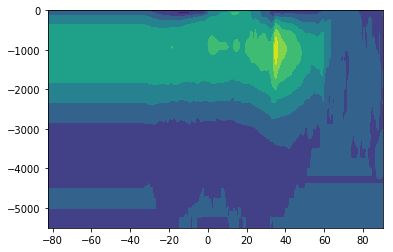

In [13]:
%%time
# plot the average AMOC
plt.contourf(lats , -depths/100., amoc_eul)

In [14]:
# do a 12 month rolling mean (This seems to be fixed in the newer verisions of xarray)
mocroll = xrdata["MOC"].rolling(time=12)

In [15]:
mocroll

DataArrayRolling [window->12,center->False,dim->time]

In [17]:
mocavg_rollmean = mocroll.mean()
#NotImplementedError: Rolling window operation does not work with dask arrays

ValueError: The overlapping depth 11 is larger than your
smallest chunk size 1. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [18]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [19]:
### The CESM Eulerian Atlantic MOC timeseries (time, depth, latitude) is at index [:,1,0,:,:]

In [20]:
amocdata = xrdata["MOC"][:,1,0,:,:].data

In [21]:
amocdata

dask.array<getitem, shape=(3216, 61, 380), dtype=float64, chunksize=(1, 61, 380)>

In [22]:
amocroll_alt = rolling_window(xrdata["MOC"].data,12)

AttributeError: 'Array' object has no attribute 'strides'

In [24]:
def amoc_rollmean(array, window):
    newarray = np.ma.masked_all(array.shape)
    np.ma.masked_equal(newarray, 0)
    w2 = int(window/2.0)
    for i in range(array.shape[0] - window + 1):
        arraytmp_sum = np.ma.zeros(array.shape[1:])
        for j in range(window):
            arraytmp_sum = np.ma.add(arraytmp_sum, array[j+i,...])
        arraytmp_mean = np.ma.divide(arraytmp_sum, window)
        newarray[w2+i,...] = arraytmp_mean
        
    return newarray

In [25]:
%%time
amoc_mean = amoc_rollmean(amocdata, 12)

CPU times: user 4min 53s, sys: 3.37 s, total: 4min 57s
Wall time: 4min 53s


In [26]:
amoc_mean.shape

(3216, 61, 380)

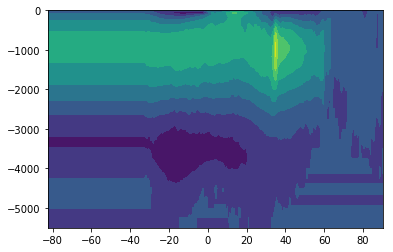

In [27]:
plt.contourf(lats, -depths/100., amoc_mean[40,...]) # plot some arbitrary point in the rolling mean

In [28]:
# depth span we are interested in (units cm)
print(xrdata["moc_z"].data[32])
print(xrdata["moc_z"].data[46])

46176.7
207487.0


In [29]:
# latitude span we are interested in (units cm)
print(xrdata["lat_aux_grid"].data[253])
print(xrdata["lat_aux_grid"].data[315])


19.8797
49.9698


In [30]:
# should be able to improve indexing with pandas range indexing get_loc ?
def get_moc_max(mocarray):
    # array: timeseries of AMOC
    # return: timeseries of AMOC max
    # Eulerian Mean MOC ; no boundary layer (and AMOC > 20 ;  AMOC < 50 N)
    amocgrid = mocarray[:,32:46,253:315]
    amocmax = np.array( [ np.ma.max(amocgrid[i]) for i in range(amocgrid.shape[0]) ] )
    return amocmax

In [31]:
amoc_max = get_moc_max(amoc_mean)

/project/p/peltier/guido/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Warning: converting a masked element to nan.


In [32]:
stime = xrdata["time"].data/365.

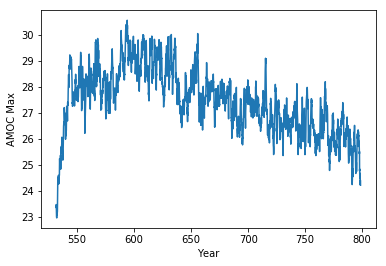

In [35]:
plt.plot(stime, amoc_max)
plt.xlabel("Year")
plt.ylabel("AMOC Max")